### CAR NK WT dist with different weights

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import lognorm,norm
from scipy.optimize import minimize
from scipy.stats import lognorm, truncnorm
import re
from pathlib import Path

In [3]:
data_file = Path.cwd().parents[0]/'data/Kasumi1_Monocyte_CD33'
MFI_range = [0, 100]
def coefficients(equation):
    numbers = re.findall(r'-?\d+\.?\d*', equation)
    coefficients = [float(num) for num in numbers]
    return coefficients
def adding_prob_dens(df):
    equation = df.apply(lambda col: col.dropna()[col.dropna().astype(str).str.contains('molecules|positivity threshold', case=False)] if col.dtype == 'object' else pd.Series(), axis=0).stack().values
    coeff = coefficients(equation[0])
    thrs = None
    if len(equation) > 1:
        thrs = coefficients(equation[1])[0]
    df = df.loc[(df.iloc[:,0] > MFI_range[0]) & (df.iloc[:,0] <= MFI_range[1])& (df.iloc[:,1] > 0)].reset_index(drop=True)
    df = df.iloc[:,:2]
    df['nmbr_mcule'] = coeff[0]**(coeff[1]*np.log10(df.iloc[:,0]) + coeff[2])
    df['prob'] = df['Count']/df['Count'].sum()
    return df,thrs
def Mixing_df(CAR_frac):
    df_CAR,thrs = adding_prob_dens(pd.read_excel(f'{data_file}/CAR-NK H.xlsx'))
    df_WT,_ = adding_prob_dens(pd.read_excel(f'{data_file}/WT H.xlsx'))
    df_WT = df_WT[['MFI', 'Count']]
    df_WT = df_WT.sample(frac=1-CAR_frac, random_state=0).sort_values(by=df_WT.columns[0]).reset_index(drop=True)
    if len(df_WT)>0:        
        df_WT.loc[df_WT.iloc[:, 0] > thrs, df_WT.columns[1]] = 0
    df_CAR = df_CAR.sample(frac=CAR_frac, random_state=0).sort_values(by=df_CAR.columns[0]).reset_index(drop=True)
    df = pd.concat([df_CAR, df_WT], axis=0)
    df = df.sort_values(by=df.columns[0]).reset_index(drop=True)
    print(len(df))
    fig,(ax0,ax1,ax2) = plt.subplots(1,3,figsize = (12,6))
    ax0.plot(df_WT['MFI'],df_WT['Count'])
    ax0.set_xlim(-1,10)
    ax1.plot(df_CAR['MFI'],df_CAR['Count'])
    ax1.set_xlim(-1,150)
    ax2.plot(df['MFI'],df['Count'])
    ax2.set_xlim(-1,150)
    ax2.set_ylim(0,100)
    plt.show()
    return df

# for 50 %

1252


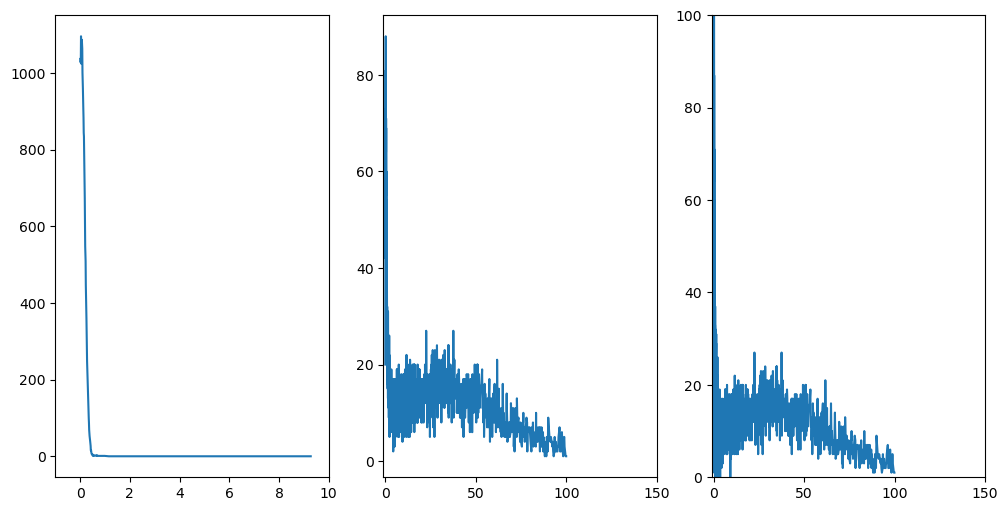

147039.77235082694
147398.52608091861
138725.03694062203
147492.07667793368
147047.09790469895
147063.9684275322
143465.9562386642
141827.3130425711
140220.0025526688
137704.50687196586
133668.0223073521
132868.63373468054
127196.84682742681
129477.72214855392
126565.72909831569
120708.66430998787
120948.13898166858
116738.27074624688
110126.90766757104
111358.7734177944
109236.10245650212
104694.28005134633
103692.4523729277
100538.98786041998
101211.71758529123
101301.78221768826
108792.38080314861
114671.7635931217
103760.58039637399
105969.07058541884
102546.72106678915
99091.8138474108
99837.55081070244
98937.14558905503
102920.47839122692
107691.05468645552
100301.65424620493
99895.5289400645
98150.23657023239
98447.72291620521
97220.64110777926
95874.7313394404
98236.61944035153
102514.58538150766
98382.06567648314
96358.81531535285
96353.40465750538
96794.04494996576
95521.03087107347
95117.92395553381
94218.53782467492
93064.1490861458
94658.96256317267
94837.05056871971
93649

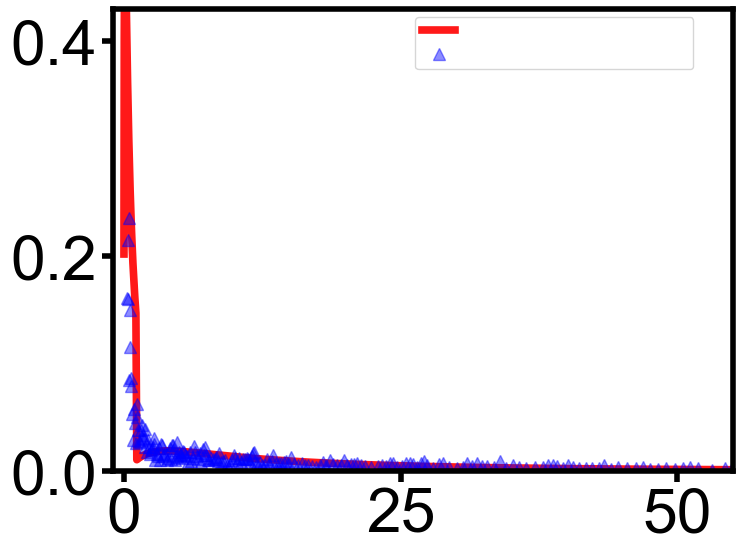

In [4]:
WT_MFI = Mixing_df(CAR_frac=0.5)
lim1, lim2, lim3 = WT_MFI['MFI'].min(), 1.14, WT_MFI['MFI'].max()
num = WT_MFI['MFI'].values
num = np.insert(num,0,0)
step = 5
num_indx = (np.linspace(0,len(num)-1,int(len(num)/step))).astype(int)
nmbr = []
for i in num_indx:
    nmbr.append(num[i])
num = np.array(nmbr)
x = (num[1:]+num[:-1])/2
bin_range = num
size = WT_MFI['Count'].sum()

lb1, ub1 = lim1, lim2
lb2, ub2 = lim2, lim3



e_num = np.repeat(WT_MFI['MFI'].values,WT_MFI['Count'].values)
count = np.array([np.sum((e_num > num[i]) & (e_num <= num[i+1])) for i in range(len(num)-1)])
def log_likelihood(params):
    mu1, sigma1, mu2, sigma2, w = params
    p1 = lognorm.pdf(x, sigma1, scale=np.exp(mu1))
    p2 = lognorm.pdf(x, sigma2, scale=np.exp(mu2))
    p1[(x < lb1) | (x > ub1)] = 0
    p2[(x < lb2) | (x > ub2)] = 0
    likelihood = (1 - w) * p1 + w * p2
    likelihood = -np.sum(count * np.log(likelihood))
    print(likelihood)
    return likelihood
# Optimization
initial_guess = np.array([0.10454514, 0.85912005, 2.86683666, 1.12676476, 0.3935105 ])
bounds = [(0.01, 1.5), (0.1, 1.5), (1, 6), (0.1, 2), (0.3, 0.5)]
result = minimize(log_likelihood, initial_guess, method='Nelder-Mead', bounds=bounds)
params = result.x
print(params.tolist())
#params = np.array([0.10454514, 0.85912005, 2.86683666, 1.12676476, 0.3935105 ])
mu1, sigma1, mu2, sigma2, w = params

print(f"mu1: {mu1}, sigma1: {sigma1}, mu2: {mu2}, sigma2: {sigma2}, w:{w}")
plt.figure(figsize=(8,6))
plt.rcParams['axes.linewidth'] = 4
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=19, length=8, width=4)
x_values = x #np.linspace(min(x), max(x), num=1000)
p1_fitted = lognorm.pdf(x_values, sigma1, scale=np.exp(mu1))
p2_fitted = lognorm.pdf(x_values, sigma2, scale=np.exp(mu2))
p1_fitted[(x_values < lb1) | (x_values > ub1)] = 0
p2_fitted[(x_values < lb2) | (x_values > ub2)] = 0
mixture_fitted = (1 - w) * p1_fitted + w * p2_fitted
pdf = count/(sum(count)*(bin_range[1:]-bin_range[:-1]))

#plt.hist(x, bins=bin_range, density=True, weights=count, label='Data', color = 'blue')
#plt.plot(x_values, p1_fitted, label='Fitted Lognormal Distribution p1', color='red')
#plt.plot(x_values, p2_fitted, label='Fitted Lognormal Distribution p2', color='blue')
plt.plot(x_values, mixture_fitted, label='Fitted Mixture Distribution', color='red',alpha=0.9,lw =5.5)
plt.plot(x,pdf,'^',markersize = 8,color='blue',alpha=0.45, label='Data')
t_size = 45
plt.xticks([0,25,50],fontname="Arial",fontsize = t_size)
plt.yticks([0.0,0.2,0.4],fontname="Arial",fontsize = t_size)
#plt.xlabel('x')
#plt.yscale('log')
plt.xlim(-1,55)
plt.ylim(0,0.43)
#plt.ylabel('Density')
plt.legend(bbox_to_anchor=(0.95, 1),fontsize=12, loc='upper right', labelcolor='white')
#plt.title('Fitted Mixture of Two Lognormal Distributions with Truncation')
plt.savefig('50_p_Mixed_dist.pdf')
plt.show()

# for 75 % CAR

1821


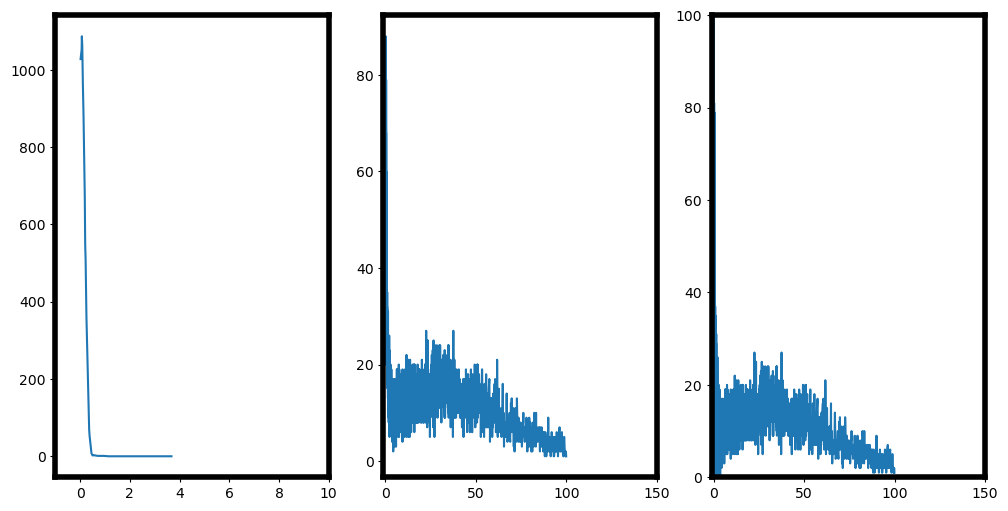

139803.7791179883
139994.06668410584
136286.93073072427
140499.03971083483
139807.0547619941
139278.03433716245
137815.74886116793
137123.20137551584
136336.25487015897
135038.5951840129
133005.73267107934
133312.97823620168
132748.94998256624
130719.07320158646
130923.61964714876
129652.19089608484
127112.23821824823
126589.48472728669
123422.79246442331
124810.40677848947
122836.55437826349
119910.59444737984
120153.14568930137
118020.37545846871
115574.12710322165
115921.03522835238
115105.42560203822
115397.5882615929
114249.29384944894
113868.84000528017
114838.48094716558
115809.90912176474
114966.58352768663
115178.83735683479
114101.41355513255
115363.65725854755
114600.68992129678
113832.79699939118
113684.66017426108
115035.51706366027
114345.95066619165
113790.70634559946
113518.48158564635
113856.6121299979
114263.62682268054
113798.2133650948
113506.37463903127
113826.57923038915
114021.44543848129
113681.20531019059
113442.576379324
113443.1826054344
113779.69617156906
11

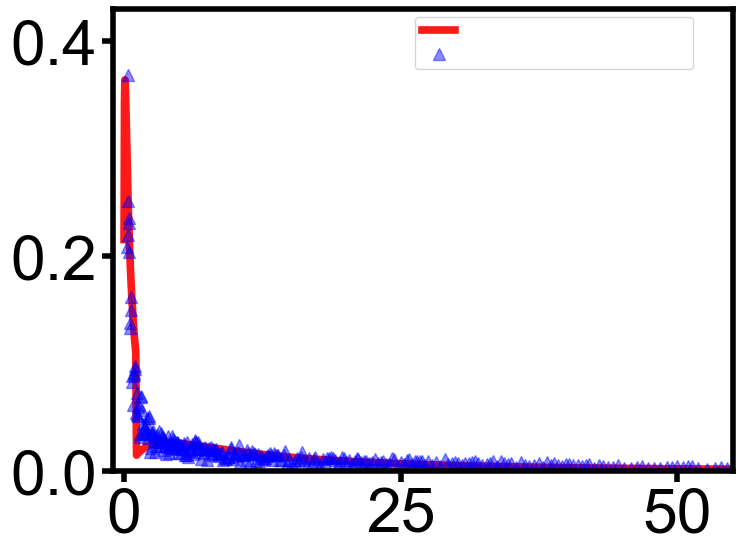

In [5]:
WT_MFI = Mixing_df(CAR_frac=0.75)
lim1, lim2, lim3 = WT_MFI['MFI'].min(), 1.14, WT_MFI['MFI'].max()
num = WT_MFI['MFI'].values
num = np.insert(num,0,0)
step = 5
num_indx = (np.linspace(0,len(num)-1,int(len(num)/step))).astype(int)
nmbr = []
for i in num_indx:
    nmbr.append(num[i])
num = np.array(nmbr)
x = (num[1:]+num[:-1])/2
bin_range = num
size = WT_MFI['Count'].sum()

lb1, ub1 = lim1, lim2
lb2, ub2 = lim2, lim3

e_num = np.repeat(WT_MFI['MFI'].values,WT_MFI['Count'].values)
count = np.array([np.sum((e_num > num[i]) & (e_num <= num[i+1])) for i in range(len(num)-1)])
def log_likelihood(params):
    mu1, sigma1, mu2, sigma2, w = params
    p1 = lognorm.pdf(x, sigma1, scale=np.exp(mu1))
    p2 = lognorm.pdf(x, sigma2, scale=np.exp(mu2))
    p1[(x < lb1) | (x > ub1)] = 0
    p2[(x < lb2) | (x > ub2)] = 0
    likelihood = (1 - w) * p1 + w * p2
    likelihood = -np.sum(count * np.log(likelihood))
    print(likelihood)
    return likelihood
# Optimization
initial_guess = np.array([0.10454514, 0.85912005, 2.86683666, 1.12676476, 0.3935105 ])
bounds = [(0.01, 1.5), (0.1, 1.5), (1, 6), (0.1, 2), (0.3, 0.55)]
result = minimize(log_likelihood, initial_guess, method='Nelder-Mead', bounds=bounds)
params = result.x
print(params.tolist())
#params = np.array([0.10454514, 0.85912005, 2.86683666, 1.12676476, 0.3935105 ])
mu1, sigma1, mu2, sigma2, w = params

print(f"mu1: {mu1}, sigma1: {sigma1}, mu2: {mu2}, sigma2: {sigma2}, w:{w}")
plt.figure(figsize=(8,6))
plt.rcParams['axes.linewidth'] = 4
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=19, length=8, width=4)
x_values = x #np.linspace(min(x), max(x), num=1000)
p1_fitted = lognorm.pdf(x_values, sigma1, scale=np.exp(mu1))
p2_fitted = lognorm.pdf(x_values, sigma2, scale=np.exp(mu2))
p1_fitted[(x_values < lb1) | (x_values > ub1)] = 0
p2_fitted[(x_values < lb2) | (x_values > ub2)] = 0
mixture_fitted = (1 - w) * p1_fitted + w * p2_fitted
pdf = count/(sum(count)*(bin_range[1:]-bin_range[:-1]))

#plt.hist(x, bins=bin_range, density=True, weights=count, label='Data', color = 'blue')
#plt.plot(x_values, p1_fitted, label='Fitted Lognormal Distribution p1', color='red')
#plt.plot(x_values, p2_fitted, label='Fitted Lognormal Distribution p2', color='blue')
plt.plot(x_values, mixture_fitted, label='Fitted Mixture Distribution', color='red',alpha=0.9,lw =5.5)
plt.plot(x,pdf,'^',markersize = 8,color='blue',alpha=0.45, label='Data')
t_size = 45
plt.xticks([0,25,50],fontname="Arial",fontsize = t_size)
plt.yticks([0.0,0.2,0.4],fontname="Arial",fontsize = t_size)
#plt.xlabel('x')
#plt.yscale('log')
plt.xlim(-1,55)
plt.ylim(0,0.43)
#plt.ylabel('Density')
plt.legend(bbox_to_anchor=(0.95, 1),fontsize=12, loc='upper right', labelcolor='white')
#plt.title('Fitted Mixture of Two Lognormal Distributions with Truncation')
plt.savefig('75_p_Mixed_dist.pdf')
plt.show()

# for 100 % CAR

2391


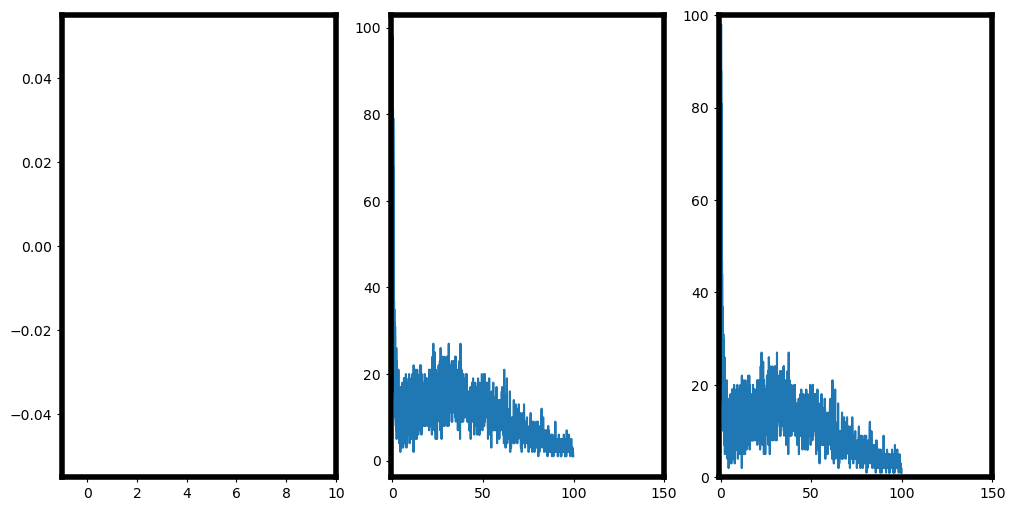

148903.64090264833
148956.26969467496
148370.97891889917
149789.4593328451
148933.21941528164
147808.36264250585
147814.9223609236
147709.66131106036
147159.26674040672
147090.64958601783
146383.0075939821
146127.77407998464
145040.22185386583
145434.16169154842
144789.80887148553
143520.99557838234
143810.20626935788
143177.7674233396
142851.15724208218
141787.43242210103
140583.41539918073
140905.52312766397
140666.85655002092
140072.26674274274
141017.57135276293
144627.14143949968
141457.31958303734
138578.61972402816
137203.03171008872
139201.4286060994
138195.02797521473
137418.7102993516
136948.07785651105
137382.15115566016
136709.0431861143
137218.7340959611
135643.01421885897
135068.97123051825
135273.65409047282
134826.55765942525
134642.15651804642
136002.2908488519
136335.02885723917
135479.80440320726
134614.0222636445
136931.54010539787
134721.45276387446
136808.36384303018
134667.96111391232
134084.4233819149
134187.20748915206
133904.3527115264
134132.6350589235
134958

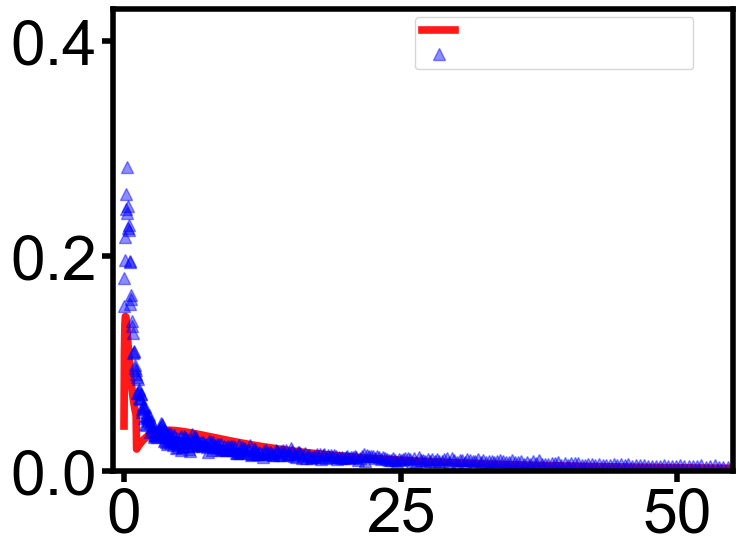

In [6]:
WT_MFI = Mixing_df(CAR_frac=1.0)
lim1, lim2, lim3 = WT_MFI['MFI'].min(), 1.14, WT_MFI['MFI'].max()
num = WT_MFI['MFI'].values
num = np.insert(num,0,0)
step = 5
num_indx = (np.linspace(0,len(num)-1,int(len(num)/step))).astype(int)
nmbr = []
for i in num_indx:
    nmbr.append(num[i])
num = np.array(nmbr)
x = (num[1:]+num[:-1])/2
bin_range = num
size = WT_MFI['Count'].sum()

lb1, ub1 = lim1, lim2
lb2, ub2 = lim2, lim3



e_num = np.repeat(WT_MFI['MFI'].values,WT_MFI['Count'].values)
count = np.array([np.sum((e_num > num[i]) & (e_num <= num[i+1])) for i in range(len(num)-1)])
def log_likelihood(params):
    mu1, sigma1, mu2, sigma2, w = params
    p1 = lognorm.pdf(x, sigma1, scale=np.exp(mu1))
    p2 = lognorm.pdf(x, sigma2, scale=np.exp(mu2))
    p1[(x < lb1) | (x > ub1)] = 0
    p2[(x < lb2) | (x > ub2)] = 0
    likelihood = (1 - w) * p1 + w * p2
    likelihood = -np.sum(count * np.log(likelihood))
    print(likelihood)
    return likelihood
# Optimization
initial_guess = np.array([0.10454514, 0.85912005, 2.86683666, 1.12676476, 0.3935105 ])
bounds = [(0.01, 1.5), (0.1, 1.5), (1, 6), (0.1, 2), (0.3, 0.85)]
result = minimize(log_likelihood, initial_guess, method='Nelder-Mead', bounds=bounds)
params = result.x
print(params.tolist())
#params = np.array([0.10454514, 0.85912005, 2.86683666, 1.12676476, 0.3935105 ])
mu1, sigma1, mu2, sigma2, w = params

print(f"mu1: {mu1}, sigma1: {sigma1}, mu2: {mu2}, sigma2: {sigma2}, w:{w}")
plt.figure(figsize=(8,6))
plt.rcParams['axes.linewidth'] = 4
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=19, length=8, width=4)
x_values = x #np.linspace(min(x), max(x), num=1000)
p1_fitted = lognorm.pdf(x_values, sigma1, scale=np.exp(mu1))
p2_fitted = lognorm.pdf(x_values, sigma2, scale=np.exp(mu2))
p1_fitted[(x_values < lb1) | (x_values > ub1)] = 0
p2_fitted[(x_values < lb2) | (x_values > ub2)] = 0
mixture_fitted = (1 - w) * p1_fitted + w * p2_fitted
pdf = count/(sum(count)*(bin_range[1:]-bin_range[:-1]))

#plt.hist(x, bins=bin_range, density=True, weights=count, label='Data', color = 'blue')
#plt.plot(x_values, p1_fitted, label='Fitted Lognormal Distribution p1', color='red')
#plt.plot(x_values, p2_fitted, label='Fitted Lognormal Distribution p2', color='blue')
plt.plot(x_values, mixture_fitted, label='Fitted Mixture Distribution', color='red',alpha=0.9,lw =5.5)
plt.plot(x,pdf,'^',markersize = 8,color='blue',alpha=0.45, label='Data')
t_size = 45
plt.xticks([0,25,50],fontname="Arial",fontsize = t_size)
plt.yticks([0.0,0.2,0.4],fontname="Arial",fontsize = t_size)
#plt.xlabel('x')
#plt.yscale('log')
plt.xlim(-1,55)
plt.ylim(0,0.43)
#plt.ylabel('Density')
plt.legend(bbox_to_anchor=(0.95, 1),fontsize=12, loc='upper right', labelcolor='white')
#plt.title('Fitted Mixture of Two Lognormal Distributions with Truncation')
plt.savefig('100_p_Mixed_dist.pdf')
plt.show()